# Liver Model Construction: Notebook

In [13]:
import os
import re
import warnings
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import equilibrator_api
from equilibrator_api import ComponentContribution, Q_
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
from mass.visualization import (
    plot_ensemble_phase_portrait, plot_ensemble_time_profile)
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)
from cobra.io.json import *
import cobra_dict as c_d
import csv
import altair as alt

MASSpy version: 0.1.5


In [14]:
import sys
print(sys.version)

3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]


In [15]:
maps_dir = os.path.abspath("maps")
data_dir = os.path.abspath("data")
dir = os.path.abspath("")
# model_dir = os.path.abspath("../massters_model")
# extra_dir=os.path.abspath("..")


### Getting reactions and metabolite data from RECON 3D

In [16]:
# making dataframe of metabolites

csv_met = os.path.join(data_dir,"met_df")
met_csv_df = pd.read_csv(csv_met,index_col="id")
metabolite_info=met_csv_df.to_dict(orient='index')



# making dataframe of reactions
csv_rxn = os.path.join(data_dir,"reaction_df")
rxn_csv_df = pd.read_csv(csv_rxn,index_col="id") 
reaction_info = rxn_csv_df.to_dict(orient='index')

### Loading cobra model

In [6]:
# Initiate empty model
trial= cobra.Model()

In [7]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in metabolite_info.items():
    met = cobra.Metabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    trial.add_metabolites(met)

In [9]:
# Loading reaction data as JSON file to maintain data types as dictionaries 
rxn_json = os.path.join(data_dir,"reaction_json")
with open(rxn_json) as json_file:
    rxn_data = json.load(json_file)

In [10]:
for reaction, info in rxn_data.items():
    reaction_obj = cobra.Reaction(reaction)
    reaction_obj.id=reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    trial.add_reaction(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    print(reaction)

HEX1
PGI
FBP
PFK
FBA
TPI
GAPD
PGK
PGM
ENO
PYK
LDH_L
ATPM


In [11]:
#adding DM_NADH 
nadhm = {'nadh_c': -1, 'h_c': 1, 'nad_c': 1}
rxn = cobra.Reaction('DM_nadh')
trial.add_reaction(rxn)
rxn.add_metabolites(nadhm)
# atpm = {'atp_c': -1,'h2o_c': -1,
#     'adp_c': 1,'h_c': 1,'pi_c': 1}
# rxn_2 = cobra.Reaction("ATPM")
# trial.add_reaction(rxn_2)
# rxn.add_metabolites(atpm)



# # add ATPM and NADHM
# atpm = {'atp_c': -1, 'h2o_c': -1, 'adp_c': 1, 'h_c': 1, 'pi_c': 1}
# rxn = cobra.Reaction('ATPM')
# model.add_reaction(rxn)
# rxn.add_metabolites(atpm)

# nadhm = {'nadh_c': -1, 'h_c': 1, 'nad_c': 1}
# rxn = cobra.Reaction('DM_nadh')
# model.add_reaction(rxn)
# rxn.add_metabolites(nadhm)

In [12]:
#Mass balance check
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

HEX1 {'charge': -1.0}
PGI {}
FBP {'charge': 2.0}
PFK {'charge': -1.0}
FBA {}
TPI {}
GAPD {'charge': -3.0}
PGK {}
PGM {}
ENO {}
PYK {'charge': 1.0}
LDH_L {'charge': -1.0}
ATPM {'charge': 1.0}
DM_nadh {'charge': 1}


In [13]:
trial.metabolites.h_c.charge= 1
# trial.metabolites.h_e.charge= 1
trial.metabolites.pi_c.charge= -2

In [14]:
#Mass balance check
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

HEX1 {}
PGI {}
FBP {}
PFK {}
FBA {}
TPI {}
GAPD {}
PGK {}
PGM {}
ENO {}
PYK {}
LDH_L {}
ATPM {}
DM_nadh {'charge': 2}


In [15]:
for met in ['glc__D_c', 'pyr_c', 'h2o_c', 'h_c', 'pi_c','lac__L_c']:
    rxn = cobra.Reaction('EX_%s' % met)
    trial.add_reaction(rxn)
    rxn.add_metabolites({met: -1})
    if met == 'glc__D_c':
        rxn.lower_bound = -1 # by convention negative exchange flux = uptake
    elif met == 'pyr_c':
        rxn.lower_bound = 0
    else:
        rxn.lower_bound = -1000

In [14]:
# solved_fluxes = minspan(trial, cores=3, verbose=False, timelimit=60)

# df = pd.DataFrame(solved_fluxes.copy(), index=[i.id for i in trial.reactions])
# df = df/df.abs().max()
# csv = os.path.join(data_dir,"minspan_trial 1")
# df.to_csv(csv  % model_name)

In [12]:
trial.objective = 'ATPM'
flux_solution = trial.optimize()
flux_solution

NameError: name 'trial' is not defined

In [10]:
from cobra.io import json
import cobra.test
import os
from os.path import join


In [11]:

trial_json = os.path.join(dir,"trial_json")
cobra.io.save_json_model(trial, trial_json )

NameError: name 'trial' is not defined

In [4]:
from minspan import minspan,nnz

## Making MASS model of glycolysis

In [16]:
liver= MassModel("Core_Model", array_type='DataFrame', dtype=np.int64)

#### Add the pathway metabolites and their information to a new MASS model

In [17]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in metabolite_info.items():
    met = MassMetabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    liver.add_metabolites(met)

In [18]:
for reaction, info in rxn_data.items():
    reaction_obj = MassReaction(reaction)
    reaction_obj.id = reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
#     if reaction_obj.id != "DM_nadh" or reaction_obj.id != 'ATPM':
    liver.add_reactions(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    print(reaction)

HEX1
PGI
FBP
PFK
FBA
TPI
GAPD
PGK
PGM
ENO
PYK
LDH_L
ATPM


In [19]:
liver.reactions.PGK.reverse_stoichiometry(inplace=True)
liver.reactions.PGM.reverse_stoichiometry(inplace=True)
# liver.reactions.PGM

Reaction identifier,PGM
Name,Phosphoglycerate mutase
Memory address,0x07efe06f9c990
Subsystem,
Kinetic Reversibility,True
Stoichiometry,3pg_c <=> 2pg_c 3-Phospho-D-glycerate <=> D-Glycerate 2-phosphate
GPR,
Bounds,"(-1000.0, 1000.0)"


### Getting Standard and Physiological Gibbs energies of reactions

In [20]:
reaction_str= []

cc = ComponentContribution()

# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.31)
cc.ionic_strength = Q_("0.144M")
cc.temperature = Q_("310.15K")
R = 0.00831446261815324 #R = 0.00831446261815324 kJ/mol
from numpy import exp as exp
Keq_df=pd.DataFrame(columns=["Reaction","Keq"])
Keq_df

,Reaction,Keq


In [21]:


for reaction in liver.reactions:
    rxn_name = reaction.id        
    if rxn_name != "ATPM":
        reaction_str = reaction.reaction.split(" <=> ")
        reactants = reaction_str[0]
        reactants = reactants.split(" + ")

        for i in range(len(reactants)):
            string = reactants[i]
            l = len(string)
            reactants[i] = string[:l-2]
            reactants[i]= "bigg.metabolite:" + reactants[i]
        reactants_string= " + ".join(reactants)
        reactants_string = str(reactants_string + " = ")   



        products = reaction_str[1]
        products = products.split(" + ")

        for i in range(len(products)):
            string = products[i]
            l = len(string)
            products[i] = string[:l-2]            
            products[i]= "bigg.metabolite:" + products[i]
        products_string= ' + '.join(products)
        reaction_to_parse = reactants_string + products_string         
        rxn_parsed = cc.parse_reaction_formula(reaction_to_parse)

        print(rxn_name)
        dG0_prime = cc.standard_dg_prime(rxn_parsed)
    #         print(f"ΔG'° = {dG0_prime}")

        dGm_prime = cc.physiological_dg_prime(rxn_parsed)
        dG_prime_value_in_kj_per_mol = dGm_prime.value.m_as("kJ/mol")
        dG0prime_value_in_kj_per_mol = dG0_prime.value.m_as("kJ/mol")
    #     print(f"ΔG'm = {dG_prime_value_in_kj_per_mol}")
        delG = dG_prime_value_in_kj_per_mol
        a = exp( -delG/ (R*310.15)) 
        reaction.Keq = a
        print(f"Keq = {a}")
#         list_keq=[reaction,a]
#         rxn_keq=pd.DataFrame(list_keq)
        df = pd.DataFrame([[reaction,a]], columns=["Reaction","Keq"])
        Keq_df.append(df)
    else:
        reaction.Keq=float("inf")
# Keq_df    

HEX1
Keq = 4959.419292148073
PGI
Keq = 0.34798040939490554
FBP
Keq = 115004.76795942851
PFK
Keq = 1454.9063091036724
FBA
Keq = 0.1620181301040788
TPI
Keq = 0.11365701527311964
GAPD
Keq = 0.0006723795415727605
PGK
Keq = 1943.5298920087905
PGM
Keq = 0.17239894103513229
ENO
Keq = 4.332330471156045
PYK
Keq = 10333.2896179346
LDH_L
Keq = 0.00013815091719569572


In [22]:
# Keq

In [23]:
#adding DM_NADH 
nadhm = {'nadh_c': -1, 'h_c': 1, 'nad_c': 1}
rxn = mass.MassReaction('DM_nadh')
liver.add_reaction(rxn)
rxn.add_metabolites(nadhm)


In [24]:
liver.reactions.DM_nadh.Keq=float("inf")

In [25]:
# atpm = {'atp_c': -1,'h2o_c': -1,
#     'adp_c': 1,'h_c': 1,'pi_c': 1}
# rxn_2 = mass.MassReaction("ATPM")
# liver.add_reaction(rxn_2)
# rxn.add_metabolites(atpm)


In [26]:
# ATPM = MassReaction(
#     "ATPM",
#     name="ATP maintenance requirement",
#     subsystem="Pseudoreaction",
#     reversible=False)
# ATPM.add_metabolites({
#     'atp_c': -1,
#     'h2o_c': -1,
#     'adp_c': 1,
#     'h_c': 1,
#     'pi_c': 1})
# DM_nadh = MassReaction(
#     "DM_nadh",
#     name="Demand NADH",
#     subsystem="Pseudoreaction",
#     reversible=False)
# DM_nadh.add_metabolites({
#     'nadh_c': -1,
#     'nad_c': 1,
#     'h_c': 1})

In [27]:
# liver.add_reactions([ATPM, DM_nadh])
# ATPM.Keq

In [28]:
for met in [
#     'co2_m', 'gdp_m', 'gtp_m', 'pi_m', 'hco3_m','h_m','atp_c','atp_m'
    'glc__D_c','h_c','h2o_c','pi_c','pyr_c','lac__L_c'
#     ,'nadh_c', 'nad_c'


           ]:
    rxn = MassReaction('EX_%s' % met)
    liver.add_reaction(rxn)
    rxn.add_metabolites({met: -1})
    if met == 'glc__D_c':
        rxn.lower_bound = -1 # negative exchange flux = uptake
    elif met == 'pyr_c':
        rxn.lower_bound = 0
    else:
        rxn.lower_bound = -1000

##  Set Fluxes

In [29]:
reaction_list=[]
for reaction in trial.reactions:
    r_id = reaction.id
    reaction_list.append(r_id)
# reaction_list.append('DM_nadh')
reaction_list

['HEX1',
 'PGI',
 'FBP',
 'PFK',
 'FBA',
 'TPI',
 'GAPD',
 'PGK',
 'PGM',
 'ENO',
 'PYK',
 'LDH_L',
 'ATPM',
 'DM_nadh',
 'EX_glc__D_c',
 'EX_pyr_c',
 'EX_h2o_c',
 'EX_h_c',
 'EX_pi_c',
 'EX_lac__L_c']

In [30]:
from minspan import minspan

In [31]:
# solved_fluxes = minspan(liver, cores=3, verbose=False, timelimit=60)

# df = pd.DataFrame(solved_fluxes.copy(), index=[i.id for i in model.reactions])
# df = df/df.abs().max()
# csv = os.path.join(data_dir,"minspan_trial 1")
# df.to_csv(csv  % model_name)

In [32]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = liver.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux 
#     * 1278.605 / 1000 # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_HEX1: 1.0
v_PGI: 1.0
v_FBP: 0.0
v_PFK: 1.0
v_FBA: 1.0
v_TPI: 1.0
v_GAPD: 2.0
v_PGK: -2.0
v_PGM: -2.0
v_ENO: 2.0
v_PYK: 2.0
v_LDH_L: 0.0
v_ATPM: 2.0
v_DM_nadh: 2.0
v_EX_glc__D_c: -1.0
v_EX_pyr_c: 2.0
v_EX_h2o_c: 0.0
v_EX_h_c: 6.0
v_EX_pi_c: 0.0
v_EX_lac__L_c: -0.0


In [33]:
liver.metabolites.h_c.charge= 1
# liver.metabolites.h_e.charge= 1
liver.metabolites.pi_c.charge= -2

In [34]:
#Function to add underscore in front of metabolite identifiers which start with a number
## fix this only after getting Keq from equlibrator because bigg doesn't have _13dpg for example
def prefix_number_id(id_str):
    """Prefix identifiers that start with numbers."""
    if re.match(r"^\d", id_str):
        id_str = "_" + id_str
    return id_str

In [35]:
#Loop to edit the names using "prefix_number_id" function defined earlier
for metabolite in liver.metabolites:
    new_met_id = prefix_number_id(metabolite.id)
    metabolite.id = new_met_id
liver.repair()

## Setting initial conditions

In [38]:
import csv
csv_ic = os.path.join(data_dir,"Concentrations_Glycolysis.csv")
# opening the CSV file
with open(csv_ic, mode ='r')as file:
   
  # reading the CSV file
    csvFile = csv.reader(file)

      # displaying the contents of the CSV file
    for name, value in csvFile:
        met_id = liver.metabolites.get_by_id(name)
        met_id.ic = float(value) #M
        print(met_id, ":", met_id.ic)
        print(name,value)

g6p_c : 0.00014
g6p_c 0.00014
glc__D_c : 0.010482807
glc__D_c 0.010482807
f6p_c : 0.000127138
f6p_c 0.000127138
fdp_c : 5.15e-05
fdp_c 5.15E-05
g3p_c : 8.78e-06
g3p_c 8.78E-06
dhap_c : 0.000176897
dhap_c 0.000176897
_3pg_c : 0.00052063
_3pg_c 0.00052063
_2pg_c : 0.000110561
_2pg_c 0.000110561
pep_c : 0.00031
pep_c 0.00031
pyr_c : 0.00048
pyr_c 0.00048
atp_c : 0.004727146
atp_c 0.004727146
adp_c : 0.001994952
adp_c 0.001994952
nad_c : 0.00182531
nad_c 0.00182531
nadh_c : 4.64e-06
nadh_c 4.64E-06
pi_c : 0.0064
pi_c 0.0064
lac__L_c : 0.003261838
lac__L_c 0.003261838


## Set H2O/H Constants

In [39]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
    "h_c",
#     'h_e','h_m',
#     'h2o_r','h2o_e',
    "h2o_c",
#     "glc__D_e", "pi_e",'pi_m',
    'pi_c'
                  ]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [40]:
for metabolite in [
#     'h_m',
"h_c", 
#     'h_e',
"h2o_c",
#     'h2o_r','h2o_e' 
]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M

In [41]:
for metabolite in liver.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

glc__D_c: 0.010482807
g6p_c: 0.00014
adp_c: 0.001994952
atp_c: 0.004727146
h_c: 1
f6p_c: 0.000127138
h2o_c: 1
pi_c: 0.0064
fdp_c: 5.15e-05
dhap_c: 0.000176897
g3p_c: 8.78e-06
nad_c: 0.00182531
nadh_c: 4.64e-06
_13dpg_c: None
_3pg_c: 0.00052063
_2pg_c: 0.000110561
pep_c: 0.00031
pyr_c: 0.00048
lac__L_c: 0.003261838


In [42]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    liver, 
    excluded_metabolites=[
    "h_c",
#         'h_e', 'h_m',
#     'h2o_r','h2o_e',
        "h2o_c",
#     "pi_e",
#     "glc__D_e", "lac__L_e",
#     "pyr_e"
    ], 
#     excluded_reactions=["Ht", "H2Ot", "H2Oter",'PIter','PIt',
#     'G6Pter','GLCter','GLCt1','PYRt2m','PEPtm',
#     'L_LACt2r','PYRt2'],

    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(liver.fixed))
# fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

['FBP', 'LDH_L']
['FBP', 'LDH_L']


,variables,reduced_costs
glc__D_c,0.010483,0.0
g6p_c,0.000269,0.0
adp_c,0.001995,0.0
atp_c,0.004727,0.0
f6p_c,0.000066,0.0
...,...,...
Keq_GAPD,0.000672,0.0
Keq_PGK,1943.529892,0.0
Keq_PGM,0.137497,0.0
Keq_ENO,4.850112,0.0


In [43]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [44]:
#Compare Results
csv_ic = os.path.join(data_dir,"Concentrations_Glycolysis.xlsx")
# ic_df = pd.read_csv(csv_ic)
# ic_df.set_index()
ic_info = load_data(
    filepath=csv_ic,
    sheet_name="Concentrations")

In [45]:
conc_solution.Keqs

Keq_HEX1     4959.419292
Keq_PGI         0.668627
Keq_PFK      1454.906309
Keq_FBA         0.162018
Keq_TPI         0.120343
Keq_GAPD        0.000672
Keq_PGK      1943.529892
Keq_PGM         0.137497
Keq_ENO         4.850112
Keq_PYK     10333.289618
Name: Keqs, dtype: float64

In [46]:
liver.parameters

{'kf': {},
 'Keq': {'Keq_HEX1': 4959.419292148073,
  'Keq_PGI': 0.34798040939490554,
  'Keq_FBP': 115004.76795942851,
  'Keq_PFK': 1454.9063091036724,
  'Keq_FBA': 0.1620181301040788,
  'Keq_TPI': 0.11365701527311964,
  'Keq_GAPD': 0.0006723795415727605,
  'Keq_PGK': 1943.5298920087905,
  'Keq_PGM': 0.17239894103513229,
  'Keq_ENO': 4.332330471156045,
  'Keq_PYK': 10333.2896179346,
  'Keq_LDH_L': 0.00013815091719569572,
  'Keq_ATPM': inf,
  'Keq_DM_nadh': inf},
 'kr': {},
 'v': {'v_HEX1': 1.0,
  'v_PGI': 1.0,
  'v_FBP': 0.0,
  'v_PFK': 1.0,
  'v_FBA': 1.0,
  'v_TPI': 1.0,
  'v_GAPD': 2.0,
  'v_PGK': -2.0,
  'v_PGM': -2.0,
  'v_ENO': 2.0,
  'v_PYK': 2.0,
  'v_LDH_L': 0.0,
  'v_ATPM': 2.0,
  'v_DM_nadh': 2.0,
  'v_EX_glc__D_c': -1.0,
  'v_EX_h_c': 6.0,
  'v_EX_h2o_c': 0.0,
  'v_EX_pi_c': 0.0,
  'v_EX_pyr_c': 2.0,
  'v_EX_lac__L_c': -0.0},
 'Custom': {},
 'Boundary': {}}

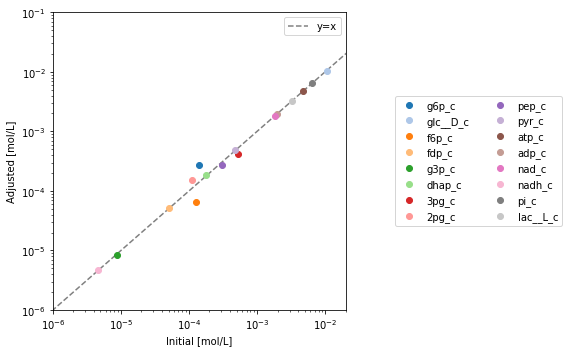

In [47]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=ic_info["Concentrations in M"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in ic_info.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-6,0.02), ylim=(1e-6,1e-1),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    liver, conc_solution, concentrations=True, inplace=True);

In [48]:
# Keq_data = pd.read_csv("./data/analysis_data/equilibrium_constants.csv", index_col=0)

# Keq_data_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
# plot_comparison(
#     x=Keq_data["Initial"], y=Keq_data["Adjusted"], ax=ax,
#     title="Equilibrium Constants comparison",
#     legend="right outside", plot_function="loglog",
#     xlim=(1e-5, 1e5), ylim=(1e-5, 1e5), 
#     xy_line=True,
#     xy_legend="best", xlabel="Initial", ylabel="Adjusted")

# Keq_data_comparison_fig.tight_layout()

In [59]:
liver.reactions.EX_glc__D_c.Keq = 1
liver.reactions.EX_h_c.Keq = 1 
liver.reactions.EX_h2o_c.Keq = 1 
liver.reactions.EX_pi_c.Keq = 1 
liver.reactions.EX_pyr_c.Keq = 1 
liver.reactions.EX_lac__L_c.Keq = 1 
# liver.reactions.EX_nadh_c.Keq = 1 
# liver.reactions.EX_nad_c.Keq = 1 

In [56]:
liver.boundary_conditions['glc__D_b']=0.010482807 ##M ## initial condition of the metabolite in the model
liver.boundary_conditions['h2o_b']=1 ##M
liver.boundary_conditions['h_b']=0.0064 ##M
liver.boundary_conditions['pi_b']=0.010482807 ##M
liver.boundary_conditions['pyr_b']=0.00048 ##M
liver.boundary_conditions['nadh_b']=4.63542E-06
liver.boundary_conditions['nad_b']=0.00182531
liver.boundary_conditions['lac__L_b']=0.003261838

In [51]:
Boundary= [
             "EX_glc__D_c", 
            "EX_h_c", 
            "EX_h2o_c",
            'EX_pyr_c',
            'EX_pi_c',
    "ATPM",
    
#     'EX_nad_c',
    "EX_lac__L_c"
]
for x in Boundary:
    a=liver.reactions.get_by_id(x)
    a.kf=1e6

In [52]:
liver.calculate_PERCs(fluxes={
                r: v for r, v in liver.steady_state_fluxes.items()
                if not (r.boundary  
#                         or r== liver.reactions.GLCter or r== glycogenolysis.reactions.PIter
#                                or r== glycogenolysis.reactions.G6Pter or r== glycogenolysis.reactions.PIt or 
#                                 r== glycogenolysis.reactions.PYRt2m or 
#                                 r== glycogenolysis.reactions.L_LACt2r or 
#                                 r== glycogenolysis.reactions.PYRt2 or 
#                                 r== glycogenolysis.reactions.PEPtm or r== glycogenolysis.reactions.GLCt1 
#                                 or r== glycogenolysis.reactions.Ht
                       )
},
                      update_reactions=True)

print("Forward Rate Constants\n----------------------")
for reaction in liver.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

Forward Rate Constants
----------------------
kf_HEX1: 20180.147787
kf_PGI: 5880.889782
kf_FBP: 100000.000000
kf_PFK: 3197810.159310
kf_FBA: 19421.090807
kf_TPI: 8446.086453
kf_GAPD: 32662020847.812099
kf_PGK: 2000727181.352774
kf_PGM: 2803.163593
kf_ENO: 20387.120284
kf_PYK: 3621918.881906
kf_LDH_L: 100000.000000
kf_ATPM: 423.088265
kf_DM_nadh: 431034.482759
kf_EX_glc__D_c: 1000000.000000
kf_EX_h_c: 1000000.000000
kf_EX_h2o_c: 1000000.000000
kf_EX_pi_c: 1000000.000000
kf_EX_pyr_c: 1000000.000000
kf_EX_lac__L_c: 1000000.000000


In [60]:
qcqa_model(liver, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

╒══════════════════════════════════════════════╕
│ MODEL ID: Core_Model                         │
│ SIMULATABLE: True                            │
│ PARAMETERS NUMERICALY CONSISTENT: True       │
╞══════════════════════════════════════════════╡
│ ============================================ │
│             CONSISTENCY CHECKS               │
│ ============================================ │
│ Elemental                                    │
│ ----------------------                       │
│ DM_nadh: {charge: 2.0}                       │
│ ============================================ │
╘══════════════════════════════════════════════╛


In [61]:
# Setup simulation object
simG=Simulation(liver, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = simG.simulate(liver, time=(0, 1e8))
# Quickly render and display time profiles
conc_sol.view_time_profile()

MassSimulationError: Could not load MassModel 'Core_Model': Cannot load SBML Model 'Core_Model' into RoadRunner due to error:
line 103: (10301 [Error]) The value of the 'id' field on every instance of the following type of object in a model must be unique: <model>, <functionDefinition>, <compartmentType>, <compartment>, <speciesType>, <species>, <reaction>, <speciesReference>, <modifierSpeciesReference>, <event>, and model-wide <parameter>s. Note that <unitDefinition> and parameters defined inside a reaction are treated separately. 
Reference: L3V1 Section 3.3
   The <parameter> id 'lac__L_c' conflicts with the previously defined <species> id 'lac__L_c' at line 27.

 Make sure the model can be exported to a valid SBML model using the 'validate_model_to_SBML' method in the SBML submodule to ensure there are no SBML compliance issues with the model.

In [ ]:
#function to set x label and y label
def set_x_label(xlabel):
    if xlabel==None:
        xlabel="Time"
    else:
        xlabel=xlabel
    return xlabel
        
def set_y_label(ylabel):        
    if ylabel==None:
        ylabel="Concentrations"
    else:
        ylabel=ylabel
    return ylabel


In [ ]:
#function to make plot typelinear log
def set_plot_type(plot_type):
    if plot_type == None:
        x_plot_type = 'log'
        y_plot_type = 'log'
    elif plot_type == "logx":
        x_plot_type = 'log'
        y_plot_type = 'linear'
    elif plot_type == "logy":
        x_plot_type = 'linear'
        y_plot_type = 'log'
    elif plot_type == "linear":
        x_plot_type = 'linear'
        y_plot_type = 'linear'
    elif plot_type == "logxlogy":
        x_plot_type = 'log'
        y_plot_type = 'log'
    return x_plot_type,y_plot_type


In [ ]:
def view_all_conc_sol(conc_sol,
#                       dynamic=True
                      xlim=None,ylim=None,plot_type=None,xlabel=None,ylabel=None,width=None,height=None):
    """Generate an interactable time profile which can zoom into the plot with interactive tooltip"""
    #Shift click to click multiple
    
    data=conc_sol.to_frame()
    data = data.reset_index().melt('Time', var_name='Metabolites', value_name='Concentrations')
    
    # Setting X limit and Y limit
    def set_ylim(ylim):
        if ylim == None:
            conc=data['Concentrations']
            ylim_max=max(conc)
            ylim=[1e-5,ylim_max]
        else:
            ylim=ylim
        return ylim
    
    def set_xlim(xlim):
        if xlim == None:
            xlim_max=data['Time'].iloc[-1]
            xlim=[1e-5,xlim_max]

        else:
            xlim=xlim
        return xlim
    xlim=set_xlim(xlim)
    ylim=set_ylim(ylim)
        
       
    # Setting type of plot
    x_plot_type=set_plot_type(plot_type)[0]
    y_plot_type=set_plot_type(plot_type)[1]
        
    # Setting x label and y label
    xlabel=set_x_label(xlabel)
    ylabel=set_y_label(ylabel)
    # Setting width and height
    if width==None:
        width=500
    else:
        width=width
        
    if height==None:
        height=300
    else:
        height=height
    
    alt.data_transformers.disable_max_rows()
    selection = alt.selection_multi(fields=['Metabolites'])
    color = alt.condition(selection,
                          alt.Color('Metabolites:N', legend=None),
                          alt.value('lightgray'))

    line = alt.Chart(data).mark_line(clip=True).encode(alt.X('Time:Q',
                                                             title=xlabel,
                                                             scale=alt.Scale(type = x_plot_type,
                                                                             padding = 10,
                                                                             domain = xlim,
#                   zero=True,
                              ),
              axis=alt.Axis(tickCount=5)),
        alt.Y('Concentrations:Q',
              title=ylabel,
              scale=alt.Scale(type=y_plot_type,
                              padding = 10,
                              domain = ylim,
#                   zero=True, 
                             ),
               axis=alt.Axis(grid=False,
                             tickCount=5)),
        color=color,
        tooltip= ["Metabolites"]+["Time"]+["Concentrations"]
    ).properties(width=width, height=height).interactive()

    
    
#         if dynamic == False:
#             A = alt.layer(line)
#         else:
    legend = alt.Chart(data).mark_point().encode(
        y=alt.Y('Metabolites:N', axis=alt.Axis(orient='right')),
        color=color
    ).add_selection(
        selection
    )
    A= line | legend
    return A

In [55]:
view_all_conc_sol(conc_sol,plot_type='logxlogy')

NameError: name 'view_all_conc_sol' is not defined